# Artificial Neural Networks for MNIST Digit Classification

The ability to classify handwritten digits is an important task with a wide range of applications. For instance, [optical character recognition (OCR)](https://en.wikipedia.org/wiki/Optical_character_recognition) technology is often used to [route mail through the postal system](https://en.wikipedia.org/wiki/Multiline_optical-character_reader). Artificial neural networks (ANNs) are particularly well-suited for classification tasks due to their ability to learn and identify patterns in data. This notebook demonstrates how artificial neural networks (ANNs) can be used to classify the handwritten digits in the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database).

# Imports

In [1]:
import gzip
import inspect
import logging
import os
import struct
import sys

import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import sklearn.metrics
import sklearn.model_selection

import torch
import torch.nn
import torch.optim
import torch.utils.data

from IPython.display import clear_output

# Data Loading

The following variables specify the location and filenames required to read the MNIST dataset.

In [2]:
root = "../datasets"
dirname = "../datasets/MNIST/raw/"
train_x_basename = "train-images-idx3-ubyte.gz"
train_y_basename = "train-labels-idx1-ubyte.gz"
test_x_basename = "t10k-images-idx3-ubyte.gz"
test_y_basename = "t10k-labels-idx1-ubyte.gz"

## Data Loading Helper Functions

### `read_labels`

The `read_labels` function is used to read the target labels of the MNIST dataset from the file specified by `filename`.

In [3]:
def read_labels(filename):
    with gzip.open(filename, "rb") as fp:
        magic, size = struct.unpack(">II", fp.read(8))
        if magic != 2049:
            raise RuntimeError(f"Magic number mismatch, expected 2049, got {magic}")
        data = fp.read()
        return np.frombuffer(data, dtype=np.uint8).astype(int)

### `read_images`

The `read_labels` function is used to read the images of the MNIST dataset from the file specified by `filename`.

In [4]:
def read_images(filename):
    with gzip.open(filename, "rb") as fp:
        magic, size, rows, cols = struct.unpack(">IIII", fp.read(16))
        if magic != 2051:
            raise RuntimeError(f"Magic number mismatch, expected 2049, got {magic}")
        data = fp.read()
        return np.frombuffer(data, dtype=np.uint8).reshape((-1,28,28)).astype(float)

## Reading the Data

After loading the data, we can see that dataset contains 60,000 training examples and 10,000 validation examples. The labels are stored as integers, while the images are stored as doubles.

In [5]:
## Uncomment the following lines to download the MNIST dataset
# import torchvision.datasets
# torchvision.datasets.MNIST(root=root, download=True, transform=None)

training_images = read_images( os.path.join(dirname, train_x_basename) )
training_labels = read_labels( os.path.join(dirname, train_y_basename) )
validation_images = read_images( os.path.join(dirname, test_x_basename) )
validation_labels = read_labels( os.path.join(dirname, test_y_basename) )

print(f"training_images:   {str(training_images.dtype) : >8} {training_images.shape}")
print(f"training_labels:   {str(training_labels.dtype) : >8} {training_labels.shape}")
print(f"validation_images: {str(validation_images.dtype) : >8} {validation_images.shape}")
print(f"validation_labels: {str(validation_labels.dtype) : >8} {validation_labels.shape}")

training_images:    float64 (60000, 28, 28)
training_labels:      int64 (60000,)
validation_images:  float64 (10000, 28, 28)
validation_labels:    int64 (10000,)


# Data Preprocessing

To effectively train an ANN for classification, it essential to first preprocess the data. In this example, we'll rescale the pixel values in the images from the original range of $[0, 255]$ to a normalized range of $[0, 1]$. This normalization process to stabilize the training process and ensure consistent convergence.

In [6]:
training_images = training_images / 255.
validation_images = validation_images / 255.

## Data Visualization

Display a few example images to gain insight into their appearances.

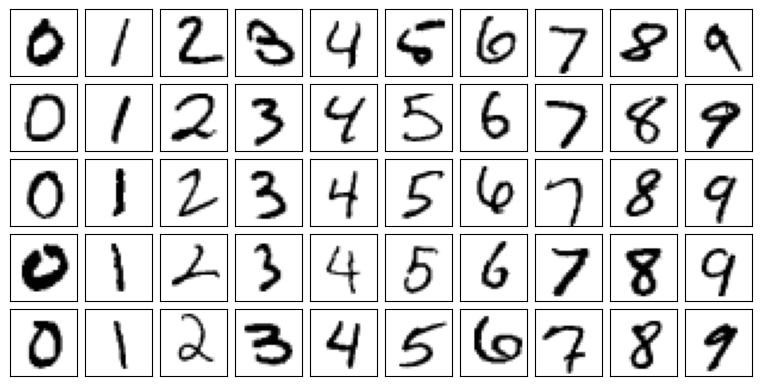

In [7]:
n_rows = 5
n_cols = 10

fig = plt.figure(constrained_layout=True, figsize=(0.75*n_cols,0.75*n_rows))
gs = mpl.gridspec.GridSpec(nrows=n_rows, ncols=n_cols, figure=fig)
for col in range(10):
    samples = validation_images[validation_labels == col]
    for row in range(n_rows):
        ax = fig.add_subplot(gs[row,col])
        ax.imshow(samples[row], cmap="binary", vmin=0., vmax=1.)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

## Digit Distribution

Generate histograms to visualize the distribution of the digits in the dataset. After analyzing these plots, it's clear that there is no data imbalance in the distribution of the target labels (digits).

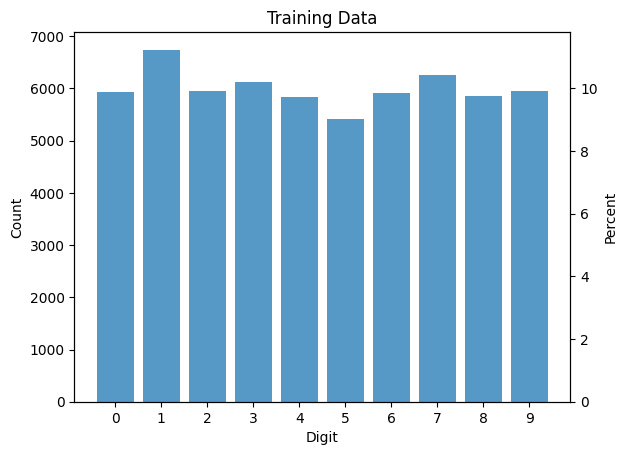

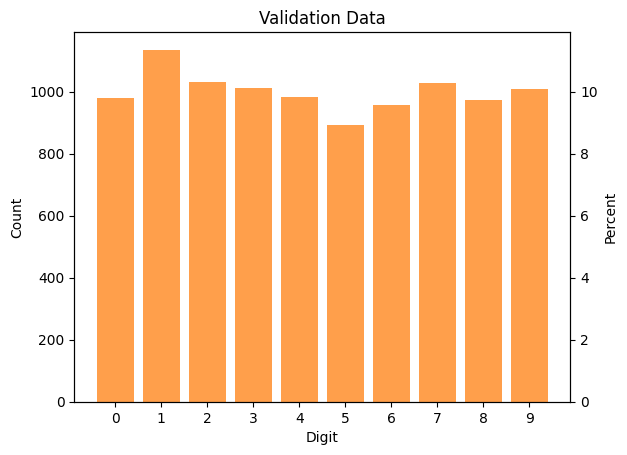

In [8]:
training_digits, training_counts = np.unique(training_labels, return_counts=True)
validation_digits, validation_counts = np.unique(validation_labels, return_counts=True)

colors =  plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig,ax = plt.subplots()
ax.bar(training_digits, training_counts, color=colors[0], alpha=0.75)
ax.xaxis.set_ticks(training_digits)
ax.set_title("Training Data")
ax.set_ylabel("Count")
ax.set_xlabel("Digit")
ax = ax.twinx()
ax.bar(training_digits, training_counts/training_counts.sum() * 100, alpha=0)
ax.set_ylabel("Percent")
plt.show()

fig,ax = plt.subplots()
ax.bar(validation_digits, validation_counts, color=colors[1], alpha=0.75)
ax.xaxis.set_ticks(validation_digits)
ax.set_title("Validation Data")
ax.set_ylabel("Count")
ax.set_xlabel("Digit")
ax = ax.twinx()
ax.bar(validation_digits, validation_counts/validation_counts.sum() * 100, alpha=0)
ax.set_ylabel("Percent")
plt.show()

# The Model (ANN)

Our neural network will consist of 3 fully connected linear layers ([torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) with Leaky ReLU activation functions ([torch.nn.LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html)) in between.

The following is a description of each layer:

1. **Input Layer**: The input layer has 128 neurons (each accepting $28\cdot28=784$ inputs &mdash; one for each pixel in the $28\times 28$ images), and applies a Leaky ReLU activation to the outputs.

2. **Hidden Layer**: The hidden layer has 64 neurons and also applies a Leaky ReLU activation to the outputs.

3. **Output Layer**: The output layer is another linear layer with 10 neurons, each corresponding to one of the 10 possible classes (i.e., the digits 0 to 9).

The Leaky ReLU activation functions help introduce non-linearity into the network, which allows it to learn complex patterns in the data. The network outputs raw non-normalized predictions for each class. These outputs are known as [logits](https://developers.google.com/machine-learning/glossary#logits) and could be passed through the [softmax function](https://en.wikipedia.org/wiki/Softmax_function) ([torch.nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)) to obtain a probability distribution for the 10 digits; outputting logits instead of a probability distribution has the potential to enhance efficiency and numerical stability of the network.

Note that the first step in the network is actually to reshape the 2D image representation into a 1D tensor using [torch.nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html). This transformation ensures that the inputs are compatible with the subsequent fully connected layers in the network.

In [9]:
class ANN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Flatten(start_dim=1, end_dim=-1),
            torch.nn.Linear(in_features=28*28, out_features=128),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(in_features=128, out_features=64),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(in_features=64, out_features=10),
            # torch.nn.Softmax(dim=1)
        )
        
    def forward(self, X):
        return self.model(X)

# Callback Handlers

The following sections define callback handlers to monitor the training progress of the neural network. While the details of these handlers are not particularly important, they play a crucial role in tracking and plotting various aspects of the training process.

## `Callback`

`Callback` is the base class for creating callback objects that can be used during training. It provides (empty) default implementations of the various callbacks.

In [10]:
class Callback:
    def on_train_begin(self, *args, **kwargs):
        pass

    def on_train_end(self, *args, **kwargs):
        pass

    def on_epoch_begin(self, *args, **kwargs):
        pass

    def on_epoch_end(self, *args, **kwargs):
        pass

    def on_mini_batch_begin(self, *args, **kwargs):
        pass

    def on_mini_batch_end(self, *args, **kwargs):
        pass

    @staticmethod
    def notify(callbacks, method_name, *args, **kwargs):
        for obj in callbacks:
            method = getattr(obj, method_name)
            method(*args, **kwargs)

## `LogPerformance`

The `LogPerformance` callback handler is used to compute and log the network's performance between epochs and mini-batches.

In [11]:
class LogPerformance(Callback):
    def __init__(
        self,
        criterion,
        training_dataloader=None,
        validation_dataloader=None,
        device="cpu",
        warm_start=False
    ):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)
        self.loss = dict()
        # self.training_loss = list()
        # self.validation_loss = list()
        # self.training_accuracy = list()
        # self.validation_accuracy = list()
        # self.mini_batch_loss = list()

    @torch.no_grad()
    def _get_performance(self, model, dataloader):
        n_correct, n_samples = 0, 0
        loss = torch.tensor(0., dtype=torch.float32).to(self.device)
        model.to(self.device).eval()
        for x_train,y_train in dataloader:
            n_samples += len(x_train)
            x_train, y_train = x_train.to(self.device), y_train.to(self.device)
            y_pred = model(x_train)
            # Scale the loss by the batch size to accumulate correctly
            loss += self.criterion(y_pred, y_train) * len(x_train) if self.criterion.reduction=="mean" else 1
            n_correct += np.sum(y_pred.to("cpu").numpy().argmax(axis=1) == y_train.to("cpu").numpy())
        if self.criterion.reduction == "mean":
            loss /= n_samples
        accuracy = 100. * n_correct / n_samples
        return loss.item(), accuracy

    def _log_training_performance(self, model, loss_log):
        if self.training_dataloader is None:
            return
        loss, accuracy = self._get_performance(model, self.training_dataloader)
        training_loss = loss_log.setdefault("training_loss", list())
        training_loss.append(loss)
        training_accuracy = loss_log.setdefault("training_accuracy", list())
        training_accuracy.append(accuracy)

    def _log_validation_performance(self, model, loss_log):
        if self.validation_dataloader is None:
            return
        loss, accuracy = self._get_performance(model, self.validation_dataloader)
        validation_loss = loss_log.setdefault("validation_loss", list())
        validation_loss.append(loss)
        validation_accuracy = loss_log.setdefault("validation_accuracy", list())
        validation_accuracy.append(accuracy)

    def _log_performance(self, model, loss_log):
        self._log_training_performance(model, loss_log)
        self._log_validation_performance(model, loss_log)

    def on_train_begin(self, n_epochs, model, logs, *args, **kwargs):
        if not self.warm_start:
            self.loss = dict()
        self._log_performance(model, self.loss)
        for key,value in self.loss.items():
            logs[key] = np.asarray(value)

    def on_epoch_begin(self, *args, **kwargs):
        mini_batch_loss = self.loss.setdefault("mini_batch_loss", list())
        mini_batch_loss.append(list())

    def on_epoch_end(self, model, logs, *args, **kwargs):
        self._log_performance(model, self.loss)
        for key,value in self.loss.items():
            logs[key] = np.asarray(value)

    def on_mini_batch_end(self, loss, logs, *args, **kwargs):
        mini_batch_loss = self.loss.setdefault("mini_batch_loss", list())
        mini_batch_loss[-1].append(loss)
        logs["mini_batch_loss"] = np.asarray(mini_batch_loss[-1])


## `PrintProgress`

The `PrintProgress` callback handler prints the performance of the network between epochs and mini-batches. The level of detail is controlled using the `verbose` parameter. It's important to note that the `CalculateLoss` handler needs to have been invoked prior to invoking this handler.

In [12]:
# 1 final score
# 2 every 10th score
# 3 every 10th score + mini batch summary
# 4 every 10th score + mini batch mini details
# 5 every 10th score + mini batch all details
# 6 every score
# 7 every score + mini batch summary
# 8 every score + mini batch mini details
# 9 every score + mini batch all details

class PrintProgress(Callback):
    def __init__(self, verbose=0, verbose_epoch_mod=10, verbose_mini_batch_mod=10):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)
        self.logger = logging.getLogger("PrintProgress")
        if not self.logger.hasHandlers():
            self.logger.addHandler( logging.StreamHandler(sys.stdout) )
        self.logger.setLevel(logging.DEBUG-verbose)

    def _log_epoch_progress_helper(self, epoch, n_epochs, logs, message_level):
        n_epochs_digits = int(np.log10(n_epochs)) + 1
        # training performance
        training_loss = logs.get("training_loss", [np.nan])[-1]
        training_accuracy = logs.get("training_accuracy", [np.nan])[-1]
        # validation performance
        validation_loss = logs.get("validation_loss", [np.nan])[-1]
        validation_accuracy = logs.get("validation_accuracy", [np.nan])[-1]
        # message
        message = (
            f"Epoch: {epoch:>{n_epochs_digits}d}/{n_epochs} ({epoch/n_epochs*100:6.2f}%)   "
            f"Training Loss: {training_loss:.6f}   Validation Loss: {validation_loss:.6f}   "
            f"Training Accuracy: {training_accuracy:6.2f}   Validation Accuracy: {validation_accuracy:6.2f}"
        )
        self.logger.log(level=logging.DEBUG-message_level, msg=message)

    def _log_epoch_progress(self, epoch, n_epochs, logs):
        if epoch == n_epochs:
            message_level = 1
        elif epoch == 0 or epoch % self.verbose_epoch_mod == 0:
            message_level = 2
        else:
            message_level = 6
        self._log_epoch_progress_helper(epoch, n_epochs, logs, message_level)

    def _log_mini_batch_progress_helper(self, epoch, n_epochs, mini_batch, n_batches, batch_size, loss, message_level):
        n_epochs_digits = int(np.log10(n_epochs)) + 1
        n_mini_batch_digits = int(np.log10(n_batches)) + 1
        message = (
            f"Epoch: {epoch:<{n_epochs_digits}d}  "
            f"[{mini_batch:>{n_mini_batch_digits}d}/{n_batches}  ({mini_batch/n_batches*100:3.0f}%)]   "
            f"Loss: {loss:15.6f}"
        )
        self.logger.log(level=logging.DEBUG-message_level, msg=message)

    def _log_mini_batch_summary(self, epoch, n_epochs, logs, message_level):
        mini_batch_loss = logs["mini_batch_loss"]
        mean, std = np.mean(mini_batch_loss), np.std(mini_batch_loss)
        n_epochs_digits = int(np.log10(n_epochs)) + 1
        message = (
            f"Epoch: {epoch:<{n_epochs_digits}d}   "
            f"Mini Batch Average Loss: {mean:.6f} +/- {std:.6f}"
        )
        self.logger.log(level=logging.DEBUG-message_level, msg=message)

    def _log_mini_batch_progress(self, epoch, n_epochs, mini_batch, n_batches, batch_size, loss, logs):
        if epoch == n_epochs or epoch % self.verbose_epoch_mod == 0:
            message_level = 4 if mini_batch % self.verbose_mini_batch_mod == 0 or mini_batch == n_batches else 5
            message_level += 4 if self.verbose >= 6 else 0
        elif mini_batch % self.verbose_mini_batch_mod == 0 or mini_batch == n_batches:
            message_level = 8
        else:
            message_level = 9
        self._log_mini_batch_progress_helper(epoch, n_epochs, mini_batch, n_batches, batch_size, loss, message_level)
        if mini_batch == n_batches:
            if epoch % self.verbose_epoch_mod == 0 or epoch == n_epochs:
                message_level = 3
                message_level += 4 if self.verbose >= 6 else 0
            else:
                message_level = 7
            self._log_mini_batch_summary(epoch, n_epochs, logs, message_level)

    def on_train_begin(self, n_epochs, model, logs, *args, **kwargs):
        self.n_epochs = n_epochs
        self._log_epoch_progress(0, self.n_epochs, logs)

    def on_epoch_end(self, epoch, model, logs, *args, **kwargs):
        self._log_epoch_progress(epoch, self.n_epochs, logs)

    def on_mini_batch_end(self, epoch, mini_batch, n_batches, batch_size, loss, logs, *args, **kwargs):
        self._log_mini_batch_progress(epoch, self.n_epochs, mini_batch, n_batches, batch_size, loss, logs)

## `PlotProgress`

The `PlotProgress` callback handler serves to visualize the loss and accuracy of the network across epochs and mini-batches. Additionally, it generates plots displaying sample digits and their predictions. Note that this handler requires the invocation of the `CalculateLoss` handler to ensure accurate data for plotting.

In [13]:
class PlotProgress(Callback):
    def __init__(self, plotting_samples, plotting_targets, limit_loss, device):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)

    def _plot_loss(self, ax, training_loss, validation_loss, limit):
        epochs = None
        if training_loss is not None:
            epochs = np.arange(len(training_loss))
            ax.plot(epochs[-limit:], training_loss[-limit:], label="Traning Loss")
        if validation_loss is not None:
            epochs = epochs if epochs is not None else np.arange(len(validation_loss))
            ax.plot(epochs[-limit:], validation_loss[-limit:], label="Validation Loss")
        if epochs is not None:
            ax.set_xlabel("Epoch")
            ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
            ax.set_ylabel("Cross Entropy Loss")
            ax.legend()

    def _plot_accuracy(self, ax, training_accuracy, validation_accuracy, limit):
        epochs = None
        if training_accuracy is not None:
            epochs = np.arange(len(training_accuracy))
            ax.plot(epochs[-limit:], training_accuracy[-limit:], label="Traning Accuracy")
        if validation_accuracy is not None:
            epochs = epochs if epochs is not None else np.arange(len(validation_accuracy))
            ax.plot(epochs[-limit:], validation_accuracy[-limit:], label="Validation Accuracy")
        if epochs is not None:
            ax.set_xlabel("Epoch")
            ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
            ax.set_ylabel("Accuracy")
            ax.legend()
    
    def _plot_samples(self, fig, gs, samples, targets, predictions):
        for ii,(sample,y_true,y_pred) in enumerate(zip(samples,targets,predictions)):
            color = "Greens" if y_pred == y_true else "Reds"
            ax = fig.add_subplot(gs[ii])
            ax.imshow(sample, cmap=color, vmin=0., vmax=1.)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if y_pred == y_true:
                color = "green"
            else:
                color = "red"
            ax.text(.99, .01, y_pred, ha="right", va="bottom", color=color, transform=ax.transAxes)

    def _get_grid_size(self, count):
        n_cols = 13
        n_rows = int(np.ceil(count/n_cols))
        return n_rows, n_cols

    @torch.no_grad()
    def _plot_results(self, epoch, training_loss, validation_loss, training_accuracy, validation_accuracy, model):
        if epoch % 10 == 0:
            model.to(self.device).eval()
            outputs = model(
                torch.from_numpy(self.plotting_samples.astype(np.float32)).to(self.device)
            ).to("cpu").numpy()

            clear_output(wait=True)
            n_rows, n_cols = 4, 2
            fig = plt.figure(figsize=(n_cols*6.4, n_rows*4.8))
            gs = mpl.gridspec.GridSpec(nrows=n_rows, ncols=n_cols, figure=fig)
            self._plot_loss(fig.add_subplot(gs[0,0]), training_loss, validation_loss, -1)
            self._plot_loss(fig.add_subplot(gs[0,1]), training_loss, validation_loss, self.limit_loss)
            self._plot_accuracy(fig.add_subplot(gs[1,0]), training_accuracy, validation_accuracy, -1)
            self._plot_accuracy(fig.add_subplot(gs[1,1]), training_accuracy, validation_accuracy, self.limit_loss)
            self._plot_samples(
                fig, gs[2:,:].subgridspec(*self._get_grid_size(len(self.plotting_samples))),
                self.plotting_samples,
                self.plotting_targets,
                outputs.argmax(axis=1)
            )
            fig.suptitle(f"Iteration {epoch}", x=(fig.subplotpars.right + fig.subplotpars.left)/2, y=1.001)
            fig.tight_layout()
            plt.show()

    def on_train_begin(self, n_epochs, model, logs, *args, **kwargs):
        self._plot_results(
            0,
            logs.get("training_loss", None),
            logs.get("validation_loss", None),
            logs.get("training_accuracy", None),
            logs.get("validation_accuracy", None),
            model
        )

    def on_epoch_end(self, epoch, model, logs, *args, **kwargs):
        self._plot_results(
            epoch,
            logs.get("training_loss", None),
            logs.get("validation_loss", None),
            logs.get("training_accuracy", None),
            logs.get("validation_accuracy", None),
            model
        )

# Traning

## Training Loop

The `train_model` function implements a standard training loop for a neural network. It performs `n_epochs` iterations of the following steps:
- In each epoch, the training data is split into mini-batches using the `dataloader`.
- For each mini-batch, the loop performs forward and backward passes through the `model`, using the `criterion` to compute the loss and the `optimizer` to update the model parameters.

The training loop allows for the integration of various callback handlers, facilitating monitoring and logging of training progress. A dictionary, `logs`, is used to store training logs generated by these callback handlers:
- Before training begins, registered callbacks are notified by calling `on_train_begin` with `n_epochs`, `model`, and `logs` as arguments.
- Before each mini-batch, registered callbacks are notified by calling `on_mini_batch_begin` with `mini_batch`, `n_batches`, `batch_size`, `epoch`, `n_epochs`, `model`, and `logs` as arguments.
- After each mini-batch, registered callbacks are notified by calling `on_mini_batch_end` with `mini_batch`, `n_batches`, `batch_size`, `epoch`, `n_epochs`, `loss`, `model`, and `logs` as arguments.
- At the end of each epoch, registered callbacks are notified by calling `on_epoch_end` with `epoch`, `n_epochs`, `model`, and `logs` as arguments.
- Once training is complete, registered callbacks are notified by calling `on_train_end` with `model` and `logs` as arguments.

In [14]:
def time_function(msg="Elapsed Time:"):
    import time
    from datetime import timedelta
    def real_timing_function(function):
        def wrapper(*args, **kwargs):
            start_time = time.time()
            res = function(*args, **kwargs)
            elapsed = time.time() - start_time
            print(msg, timedelta(seconds=elapsed))
            return res
        return wrapper
    return real_timing_function

@time_function("Training Time:")
def train_model(
    model,
    device,
    dataloader,
    criterion,
    optimizer,
    n_epochs,
    callbacks=None,
    logs=None
):
    if callbacks is None:
        callbacks = list()
    if logs is None:
        logs = dict()
    
    # notify each callback of the beginning of training
    Callback.notify(
        callbacks, "on_train_begin",
        n_epochs=n_epochs, model=model, logs=logs
    )
    
    for epoch in range(1,n_epochs+1):
        # notify each callback of the beginning of the epoch
        Callback.notify(
            callbacks, "on_epoch_begin",
            epoch=epoch, n_epochs=n_epochs, model=model, logs=logs
        )
        for mini_batch,(x_train,y_train) in enumerate(dataloader, 1):
            # notify each callback of the mini batch
            Callback.notify(
                callbacks, "on_mini_batch_begin",
                mini_batch=mini_batch, n_batches=len(dataloader), batch_size=len(x_train),
                epoch=epoch, n_epochs=n_epochs, model=model, logs=logs
            )
            
            # zero out the generator gradients
            optimizer.zero_grad()
            model.to(device).train()

            # pass the data through the model and compute the loss
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)

            # compute the gradients and update the model's weights
            loss.backward()
            optimizer.step()
    
            # notify each callback of the mini batch
            Callback.notify(
                callbacks, "on_mini_batch_end",
                mini_batch=mini_batch, n_batches=len(dataloader), batch_size=len(x_train),
                epoch=epoch, n_epochs=n_epochs,
                loss=loss.item(), model=model, logs=logs
            )
        
        # notify each callback of the end of the epoch
        Callback.notify(
            callbacks, "on_epoch_end",
            epoch=epoch, n_epochs=n_epochs, model=model, logs=logs
        )

    # notify each callback of the end of training
    Callback.notify(
        callbacks, "on_train_end",
        model=model, logs=logs
    )

## Parameters

The following variables control the training loop:
- `n_epochs` &mdash; specifies the number of training epochs
- `batch_size` &mdash; determines the number of samples used in each mini-batch
- `shuffle` &mdash; when set to `True`, the data is reshuffled at the beginning of every epoch
- `device` &mdash; specifies whether calculations are performed on the GPU (set to `'cuda'`) or the CPU (set to `'cpu'`)

The model, `ann`, is also initialized here as it is needed later when the optimizer is defined.

In [15]:
n_epochs = 50
batch_size = 256
shuffle = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ann = ANN()

print(device)
print(ann)

cpu
ANN(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
    (5): Linear(in_features=64, out_features=10, bias=True)
  )
)


## Loss Function

For our loss function, we have chosen [cross-entropy](https://en.wikipedia.org/wiki/Cross-entropy), which measures the dissimilarity between two probability distributions. Our neural network can be viewed as producing a probability distribution over each of the 10 digits for a given image (note that softmax must be applied to the output logits beforehand). This probability distribution is then compared against the true probability distribution, where all digits except the target have a probability of 0 and the true target has a probability of 1.

In PyTorch, [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) combines the softmax function and the cross-entropy loss calculation into a single function &mdash; given the logits output by the neural network and the true class labels, [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) internally applies softmax to the logits to obtain predicted probabilities and then computes the cross-entropy loss.

In [16]:
cross_entropy_loss = torch.nn.CrossEntropyLoss(reduction="mean")

## Optimizer

Here, we define our optimizer, a modified version of gradient descent called Adam ([torch.optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)).

In [17]:
adam_optimizer = torch.optim.Adam(ann.parameters())

## Data Loaders

For ease of training, our dataset will be loaded into a [torch.utils.data.TensorDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) and accessed using a [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

### Training DataLoader

In [18]:
training_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(training_images.astype(np.float32)),
    torch.from_numpy(training_labels)
)
training_dataloader = torch.utils.data.DataLoader(
    training_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
)

### Validation DataLoader

In [19]:
validation_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(validation_images.astype(np.float32)),
    torch.from_numpy(validation_labels)
)
validation_dataloader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=False
)

## Initialize Callbacks

Here we initialize the callback objects and add them to the `callbacks` list. To reduce the computation required to log the training and validation loss between each epoch, a subset of size $500=50\cdot10$ from their respective datasets is utilize.

In [20]:
n_samples = 50
training_idx = np.concatenate([
    np.where(training_labels == ii)[0][:n_samples]
    for ii in range(10)
])
validation_idx = np.concatenate([
    np.where(validation_labels == ii)[0][:n_samples]
    for ii in range(10)
])
log_performance = LogPerformance(
    criterion=cross_entropy_loss,
    training_dataloader=torch.utils.data.DataLoader(
        dataset=torch.utils.data.TensorDataset(
            torch.from_numpy(training_images[training_idx].astype(np.float32)),
            torch.from_numpy(training_labels[training_idx])
        ),
        batch_size=2*batch_size
    ),
    validation_dataloader=torch.utils.data.DataLoader(
        dataset=torch.utils.data.TensorDataset(
            torch.from_numpy(validation_images[validation_idx].astype(np.float32)),
            torch.from_numpy(validation_labels[validation_idx])
        ),
        batch_size=2*batch_size
    ),
    device=device
)

print_progress = PrintProgress(
    verbose=6
)

n_samples = 13
idx = np.concatenate([
    np.where(validation_labels == ii)[0][:n_samples]
    for ii in range(10)
])
plotting_samples = validation_images[idx]
plotting_targets = validation_labels[idx]
plot_progress = PlotProgress(
    plotting_samples=plotting_samples,
    plotting_targets=plotting_targets,
    limit_loss=10,
    device=device
)

callbacks = [log_performance, print_progress, plot_progress]

## Train the Model

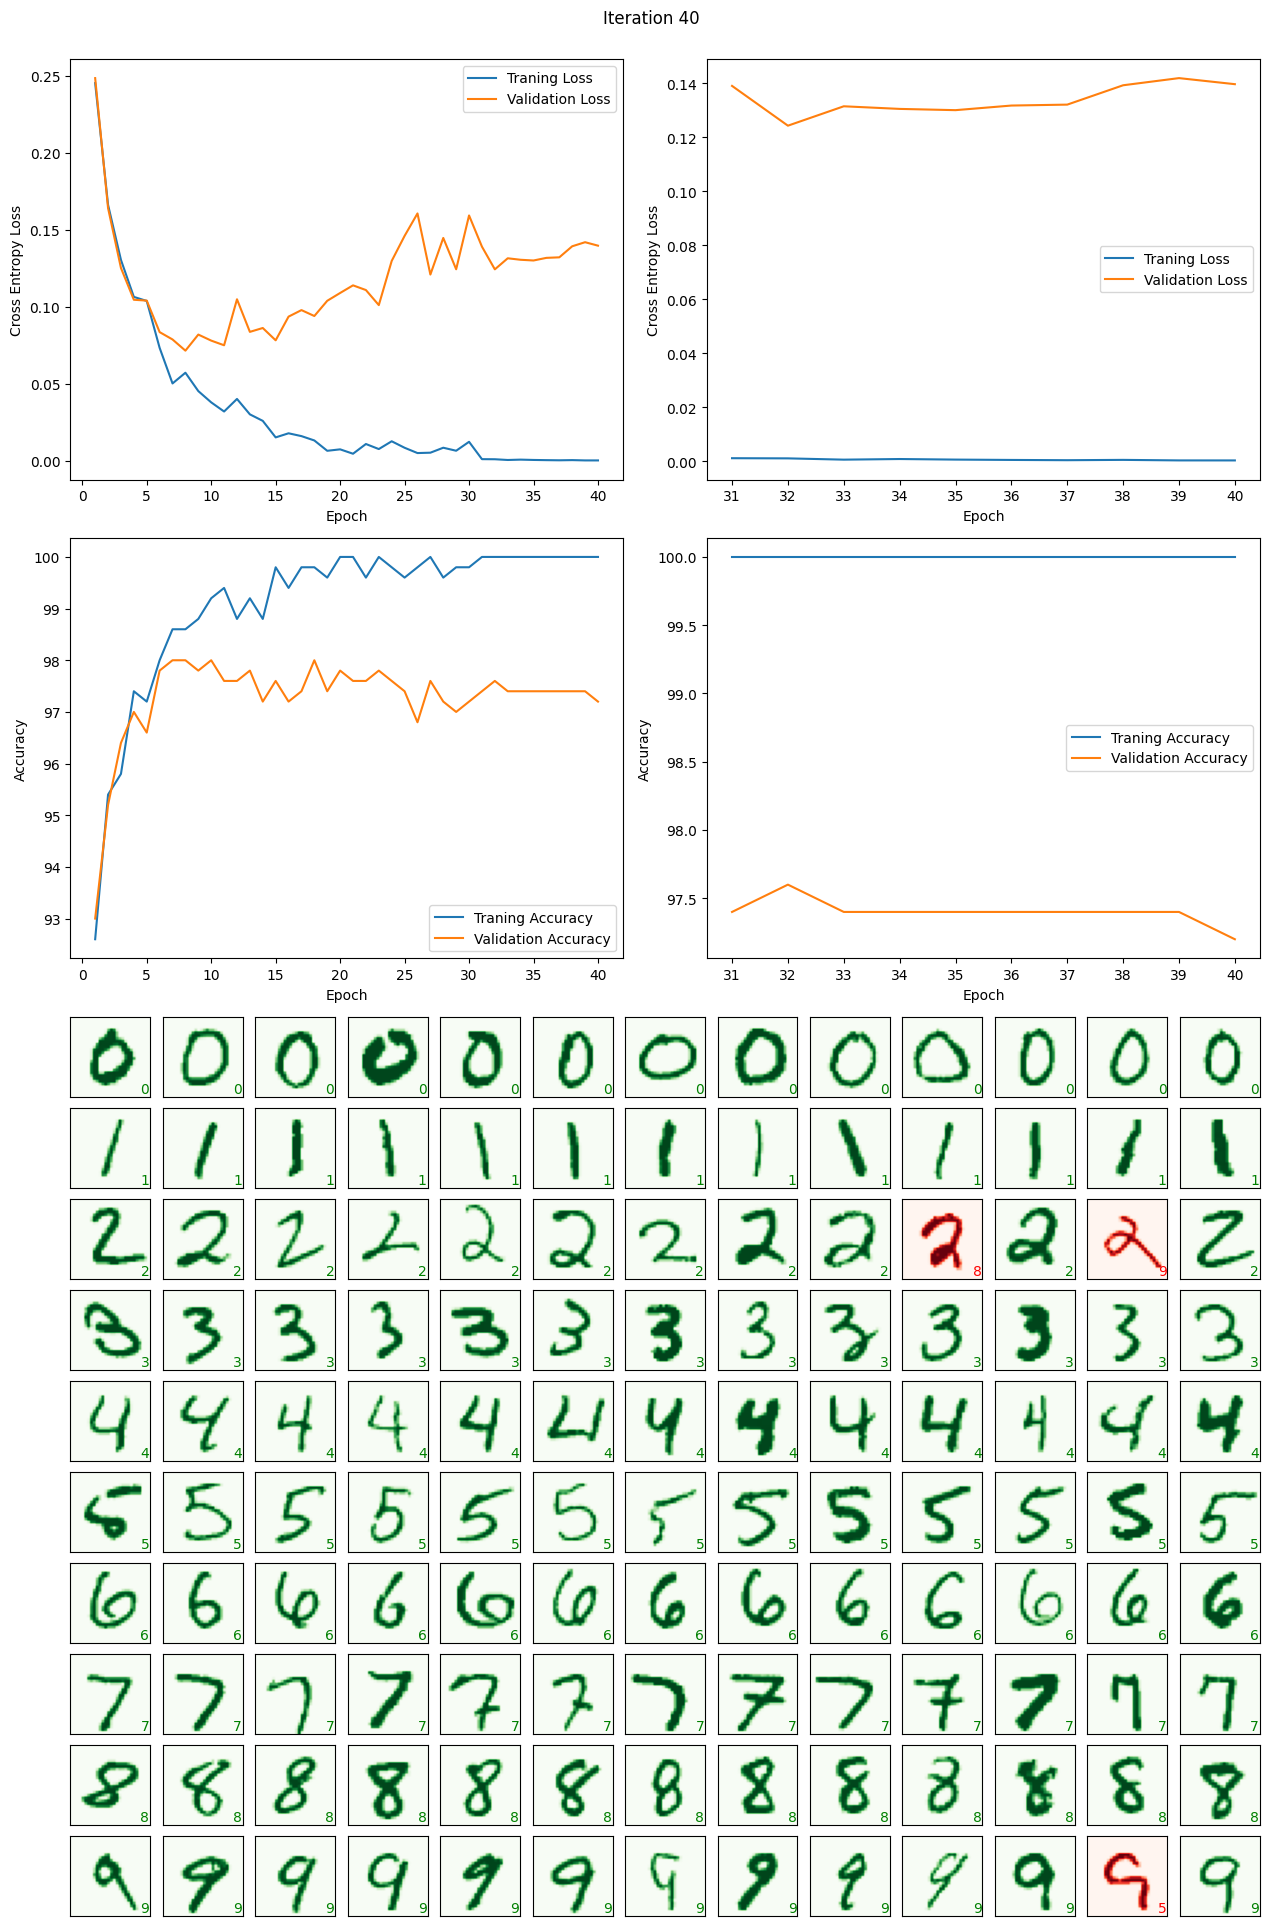

Epoch: 41/50 ( 82.00%)   Training Loss: 0.049642   Validation Loss: 0.231881   Training Accuracy:  98.60   Validation Accuracy:  96.80
Epoch: 42/50 ( 84.00%)   Training Loss: 0.008270   Validation Loss: 0.121177   Training Accuracy:  99.80   Validation Accuracy:  97.60
Epoch: 43/50 ( 86.00%)   Training Loss: 0.002794   Validation Loss: 0.191757   Training Accuracy: 100.00   Validation Accuracy:  97.60
Epoch: 44/50 ( 88.00%)   Training Loss: 0.000652   Validation Loss: 0.161526   Training Accuracy: 100.00   Validation Accuracy:  97.40
Epoch: 45/50 ( 90.00%)   Training Loss: 0.000749   Validation Loss: 0.154923   Training Accuracy: 100.00   Validation Accuracy:  97.60
Epoch: 46/50 ( 92.00%)   Training Loss: 0.000410   Validation Loss: 0.163569   Training Accuracy: 100.00   Validation Accuracy:  97.60
Epoch: 47/50 ( 94.00%)   Training Loss: 0.000331   Validation Loss: 0.161147   Training Accuracy: 100.00   Validation Accuracy:  97.60
Epoch: 48/50 ( 96.00%)   Training Loss: 0.000252   Vali

In [ ]:
logs = dict()
train_model(
    model=ann,
    device=device,
    dataloader=training_dataloader,
    criterion=cross_entropy_loss,
    optimizer=adam_optimizer,
    n_epochs=n_epochs,
    callbacks=callbacks,
    logs=logs
)

# Performance Evaluation

The loss and accuracy plots above suggest that the network may be overfitting on the training data. The following section provides a closer look at the performance on the training and validation datasets.

## Performance Evaluation Helper Functions

### `plot_confusion_matrix`

The following helper function calculates and visualizes the confusion matrix based for the given true labels, `y_true`, and predicted labels, `y_pred`.

In [22]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", xlabel="Predicted Label", ylabel="True Label", ax=None):
    ax_is_none = ax is None
    if ax_is_none:
        fig,ax = plt.subplots(figsize=(5,5))
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
    t_hold = confusion_matrix.max() / 2
    mat = ax.imshow(confusion_matrix, cmap="viridis")
    for ii in range(len(confusion_matrix)):
        for jj in range(len(confusion_matrix)):
            value = confusion_matrix[ii, jj]
            color = "white" if value <= t_hold else "black"
            plt.text(jj, ii, value, ha="center", va="center", color=color)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(mat, cax=cax)
    ax.set_xticks(np.arange(len(confusion_matrix)), np.arange(len(confusion_matrix)))
    ax.set_yticks(np.arange(len(confusion_matrix)), np.arange(len(confusion_matrix)))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if ax_is_none:
        plt.show()

### `plot_misclassifications`

The following helper function is utilized to plot misclassified images. It is assumed that `misclassified_images` is a list of lists, where each inner list contains pairs of the form (image, actual, prediction). These inner lists are arranged vertically as columns within a single comprehensive figure.

In [23]:
def plot_misclassifications(misclassifications):
    fig,ax = plt.subplots(figsize=(1, 1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.text(.01, .01, "A", ha="left", va="bottom", color="green", transform=ax.transAxes)
    ax.text(.99, .01, "P", ha="right", va="bottom", color="red", transform=ax.transAxes)
    ax.text(1.1, .99, "A = Actual\nP = Predicted", ha="left", va="top", color="black", transform=ax.transAxes)
    ax.text(.5, .5, "#", ha="center", va="center", color="black", fontsize=30, transform=ax.transAxes)
    plt.show()

    n_cols = len(misclassifications)
    n_rows = max(len(results) for results in misclassifications)
    fig = plt.figure(constrained_layout=True, figsize=(0.75*n_cols,0.75*n_rows))
    gs = mpl.gridspec.GridSpec(nrows=n_rows, ncols=n_cols, figure=fig)
    for col,results in enumerate(misclassifications):
        for row,(image,actual,prediction) in enumerate(results):
            ax = fig.add_subplot(gs[row,col])
            ax.imshow(image, cmap="binary", vmin=0., vmax=1.)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            # ax.text(0, 0, label, fontsize=12, ha='right', va='bottom', transform=plt.gca().transData)
            ax.text(.01, .01, actual, ha="left", va="bottom", color="green", transform=ax.transAxes)
            ax.text(.99, .01, prediction, ha="right", va="bottom", color="red", transform=ax.transAxes)
    plt.show()

## Obtaining Predictions from Probabilities

To evaluate the network's performance, we must obtain predictions for both the training and validation samples. Recall that our neural network generates logits, which can be passed through the softmax function to obtain the probabilities of each sample belonging to one of the ten digits. By selecting the digit with the highest corresponding probability, we can derive a single prediction for each associated sample. However, to reduce the computational load, we can bypass the use of softmax and directly select the digit with the highest corresponding logit.

In [24]:
with torch.no_grad():
    ann.to(device).eval()
    training_predictions = ann(
        torch.from_numpy(training_images.astype(np.float32)).to(device)
    ).to("cpu").numpy().argmax(axis=1)
    validation_predictions = ann(
        torch.from_numpy(validation_images.astype(np.float32)).to(device)
    ).to("cpu").numpy().argmax(axis=1)

## Confusion Matrices

It is evident from the following confusion matrices that the model performs significantly better on the training data compared to the validation data.

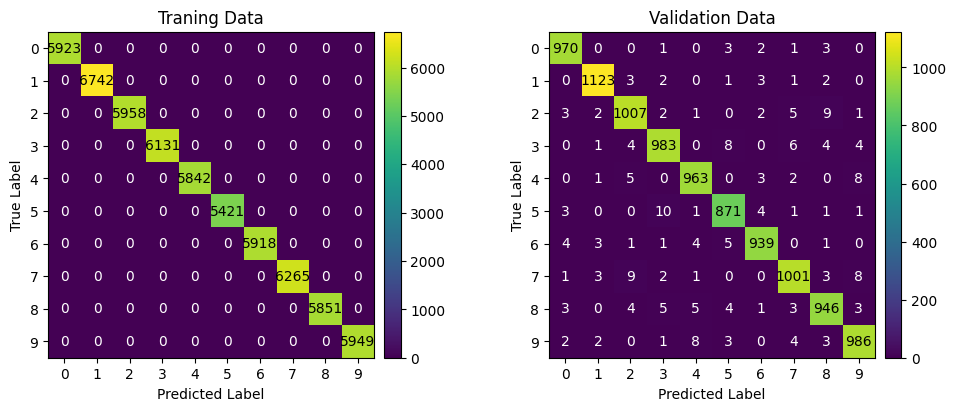

In [25]:
n_cols = 2
n_rows = 1
fig = plt.figure(constrained_layout=True, figsize=(5*n_cols,4*n_rows))
gs = mpl.gridspec.GridSpec(nrows=n_rows, ncols=n_cols, figure=fig)
plot_confusion_matrix(training_labels, training_predictions, title="Traning Data", ax=fig.add_subplot(gs[0]))
plot_confusion_matrix(validation_labels, validation_predictions, title="Validation Data", ax=fig.add_subplot(gs[1]))
plt.show()

## False Positives

In a multi-class classification problem, a false positive occurs when the model incorrectly predicts a sample as belonging to a certain class when it actually belongs to a different class.

In the following figure, each column represents a distinct digit (i.e., the $n$th column represents the digit $n$, starting from 0), with the images in that column being misclassified as the respective digit.

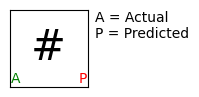

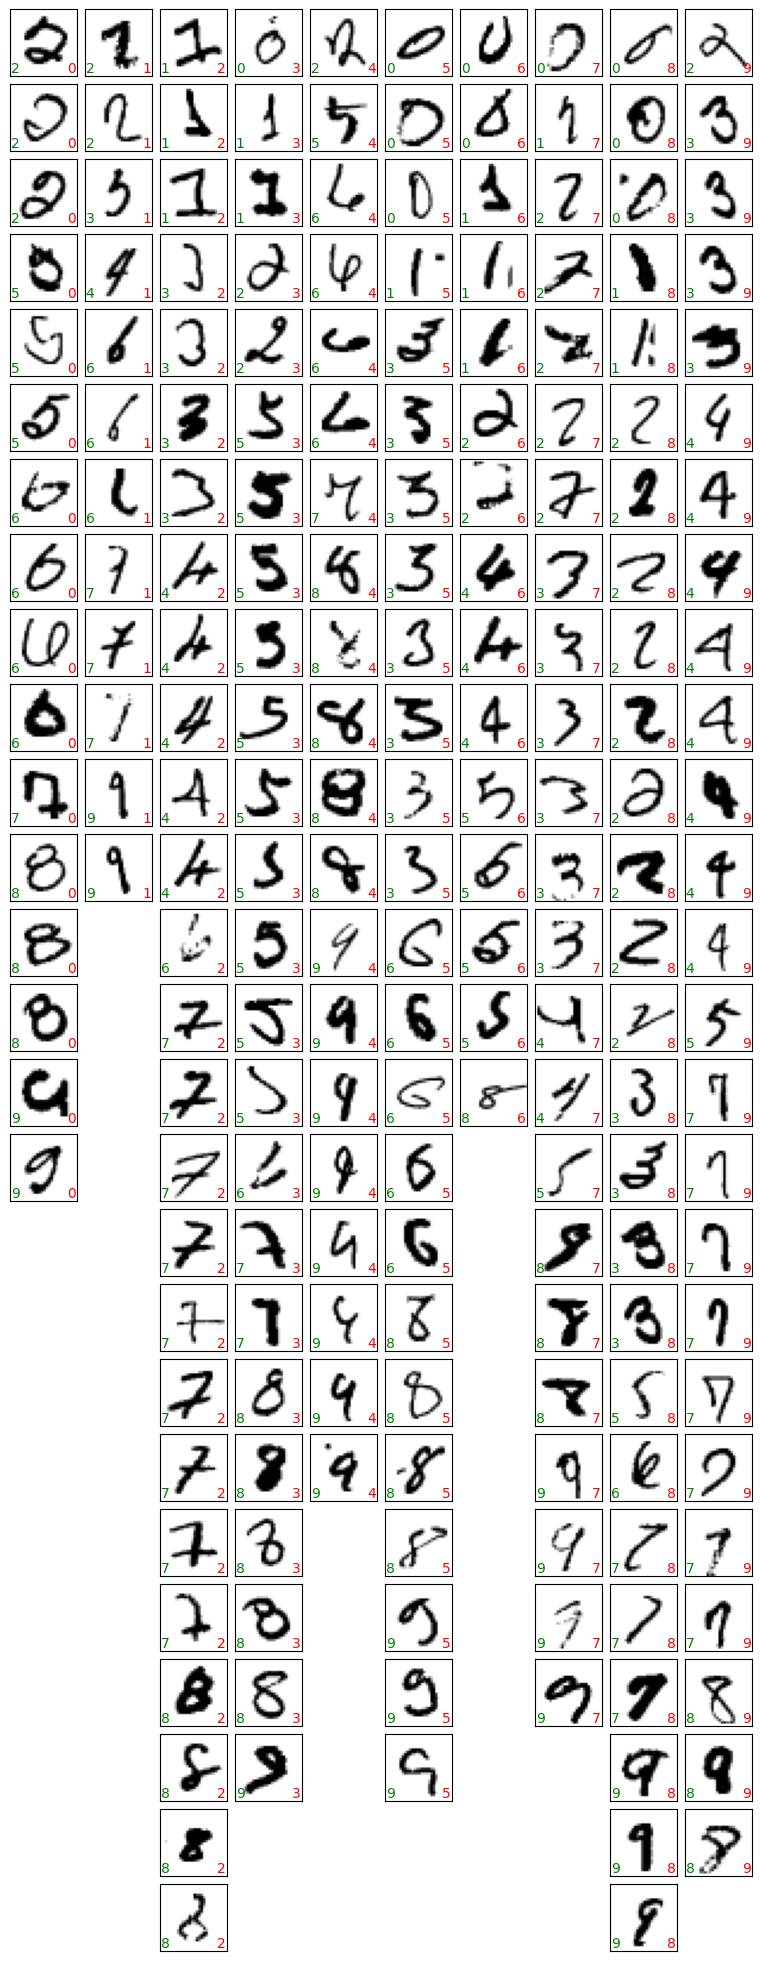

In [26]:
misclassified_images = list()
miscalssified_idx = validation_labels != validation_predictions
for digit in range(10):
    digit_idx = validation_predictions == digit
    sorted_idx = np.argsort(validation_labels[miscalssified_idx & digit_idx])
    idx = np.arange(len(validation_predictions))[miscalssified_idx & digit_idx][sorted_idx]
    misclassified_images.append(
        list(zip(validation_images[idx], validation_labels[idx], validation_predictions[idx] ))
    )

plot_misclassifications(misclassified_images)

## False Negatives

In a multi-class classification problem, a false negative occurs when the model incorrectly predicts a sample as not belonging to a certain class when it actually belongs to that class.

In the following figure, each column represents a distinct digit (i.e., the $n$th column represents the digit $n$, starting from 0), with the images in that column being misclassified as a different digit.

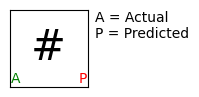

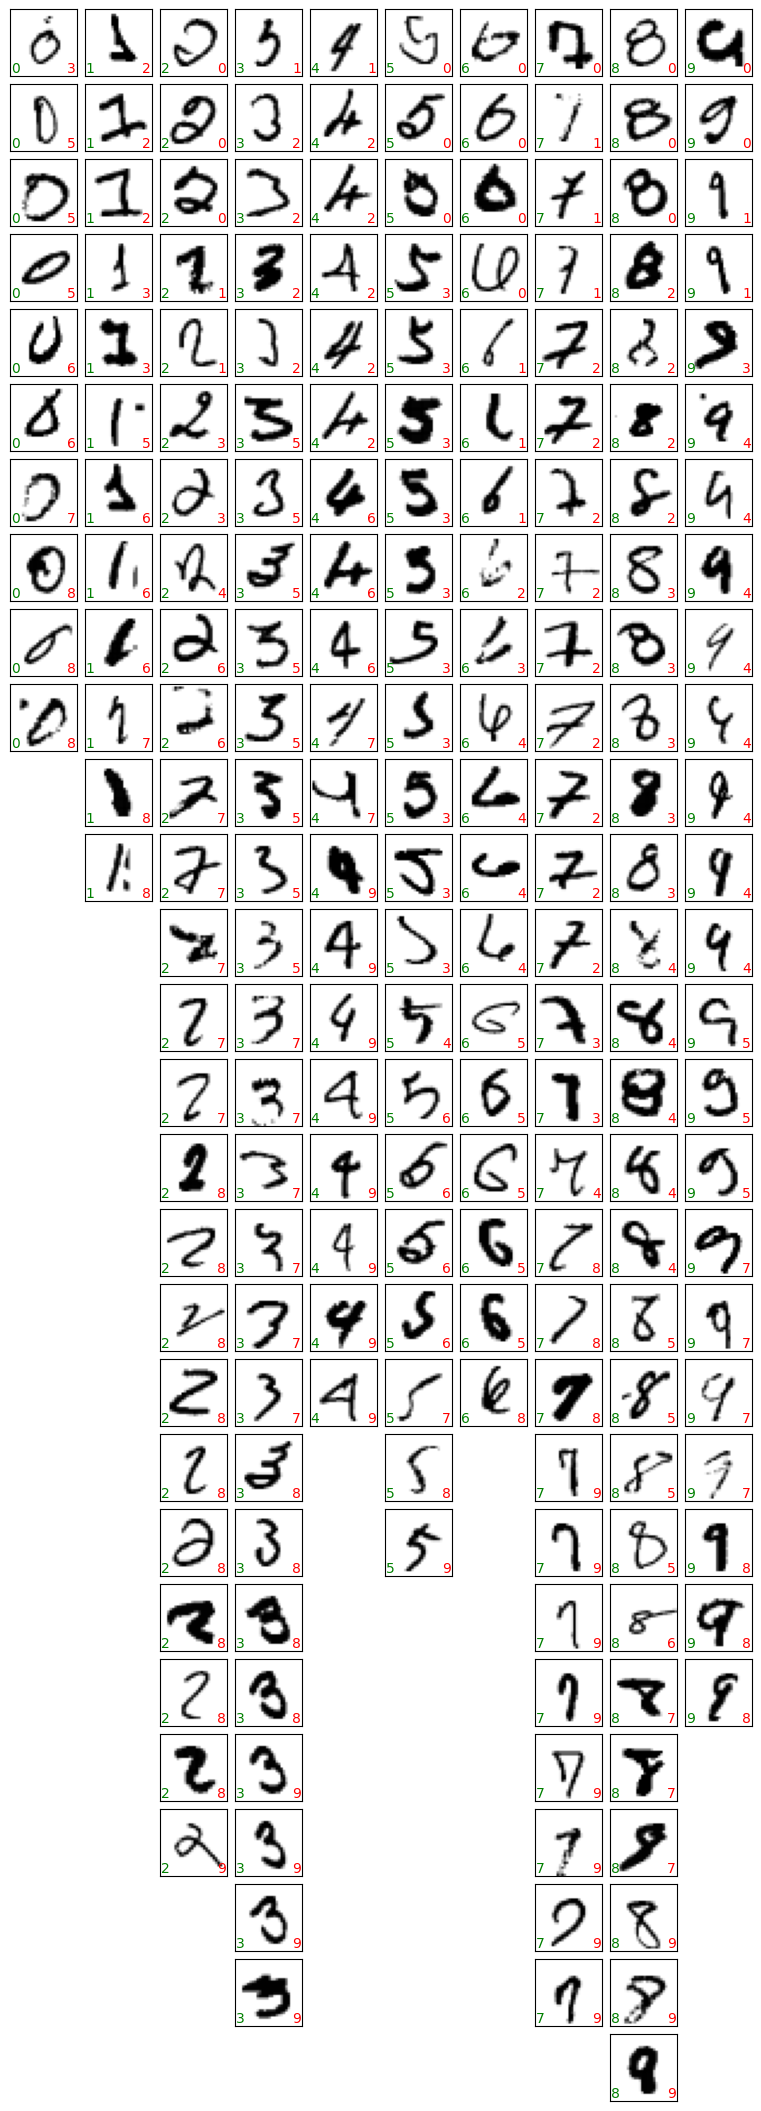

In [27]:
misclassified_images = list()
miscalssified_idx = validation_labels != validation_predictions
for digit in range(10):
    digit_idx = validation_labels == digit
    sorted_idx = np.argsort(validation_predictions[miscalssified_idx & digit_idx])
    idx = np.arange(len(validation_predictions))[miscalssified_idx & digit_idx][sorted_idx]
    misclassified_images.append(
        list(zip(validation_images[idx], validation_labels[idx], validation_predictions[idx] ))
    )

plot_misclassifications(misclassified_images)